In [1]:
import os
import torch
from torch import nn
from torchviz import make_dot
from IPython.display import Image, display

import eval
import test_stuff_functions as tsf

from libs.core import load_config
from libs.datasets import make_dataset, make_data_loader
from libs.modeling import make_meta_arch
from libs.utils import fix_random_seed

%load_ext autoreload
%autoreload 2

## Evaluate Pretrained

In [26]:
eval.run(config='configs/UMMAFormer/psynd_byola.yaml', ckpt='Pretrained/psynd_byola/epoch_015.pth.tar', epoch=15)

{'dataset': {'audio_feat_folder': './data/Psynd/feats/byola',
             'audio_file_ext': None,
             'audio_input_dim': 2048,
             'crop_ratio': [0.9, 1.0],
             'default_fps': None,
             'downsample_rate': 1,
             'feat_stride': 1,
             'file_ext': '.npy',
             'file_prefix': 'none',
             'force_upsampling': True,
             'input_dim': 0,
             'json_file': './data/Psynd/annotations/metadatabyola.json',
             'max_seq_len': 768,
             'num_classes': 1,
             'num_frames': 1,
             'trunc_thresh': 0.5},
 'dataset_name': 'psynd',
 'devices': [0],
 'init_rand_seed': 1234567891,
 'loader': {'batch_size': 8, 'num_workers': 4},
 'model': {'audio_input_dim': 2048,
           'backbone_arch': (2, 2, 5),
           'backbone_type': 'convHRLRFullResSelfAttTransformerRevised',
           'embd_dim': 256,
           'embd_kernel_size': 3,
           'embd_with_ln': True,
           'fpn_dim':

In [27]:
file_path = '/home/ben/Thesis/UMMAFormerTest/Pretrained/psynd_byola/test_results.txt'
detection_df, proposal_df = tsf.format_results_as_matrix(file_path)

# Display the matrices
print("Detection Results:")
print(detection_df)

print("\nProposal Results:")
print(proposal_df)

Detection Results:
   average-mAP  mAP@0.50  mAP@0.55  mAP@0.60  mAP@0.65  mAP@0.70  mAP@0.75  \
0        96.97     100.0     100.0     100.0     100.0     100.0    98.574   

   mAP@0.80  mAP@0.85  mAP@0.90  mAP@0.95  
0    98.574    97.322    95.363     79.87  

Proposal Results:
    AR@10   AR@20   AR@50  AR@100
0  97.595  97.595  97.595  97.595


## Build Model

In [3]:
# model to load
config='configs/UMMAFormer/psynd_byola.yaml'
ckpt='Pretrained/psynd_byola/epoch_015.pth.tar'
epoch=15
_ = fix_random_seed(0, include_cuda=True)

In [4]:
# load config
if os.path.isfile(config):
    cfg = load_config(config)

In [5]:
# data
val_dataset = make_dataset(
    cfg['dataset_name'], False, cfg['test_split'], **cfg['dataset']
)
# set bs = 1, and disable shuffle
val_loader = make_data_loader(
    val_dataset, False, None, 1, cfg['loader']['num_workers']
)

['test'] subset has 79 videos


In [6]:
sample = next(iter(val_loader))
sample[0]["feats"].shape

torch.Size([2048, 768])

In [7]:
test_tensor = torch.tensor([i for i in range(800)])
dummy_sample = [{'video_id': '3434_3434',
                 'feats': torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]),
                 #'feats': test_tensor,
                 'segments': torch.tensor([[1.0, 2.0]]),
                 'labels': torch.tensor([0]),
                 'fps': 12.48324147177119,
                 'duration': 33.565,
                 'feat_stride': 0.5455729166666666,
                 'feat_num_frames': 0.5455729166666666}]

In [8]:
# model
model = make_meta_arch(cfg['model_name'], **cfg['model'])
# only one gpu
model = nn.DataParallel(model, device_ids=cfg['devices'])

In [9]:
# load checkpoint
print("=> loading checkpoint '{}'".format(ckpt))
# load ckpt, reset epoch / best rmse
checkpoint = torch.load(
    ckpt,
    map_location = lambda storage, loc: storage.cuda(cfg['devices'][0])
)
# load ema model instead
print("Loading from EMA model ...")
model.load_state_dict(checkpoint['state_dict_ema'])
del checkpoint

=> loading checkpoint 'Pretrained/psynd_byola/epoch_015.pth.tar'
Loading from EMA model ...


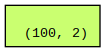

In [ ]:
# Generate a computational graph using torchviz
model.eval()
sample_input = sample 
output = model(sample_input)  # Forward pass through the model
graph = make_dot(output[0]['segments'], params=dict(model.named_parameters()))  # Create the graph
# Render the graph and display it in the notebook
graph.format = "png"  # Set the format to PNG
graph.render("model_visualization", format="png", cleanup=True)  # Render the graph and clean up intermediate files
display(Image("model_visualization.png"))  # Display the PNG in the notebook

In [10]:
# create batched features and masks (B,C,T)
# upsamples sequence length to max_sequence length (768)
model.eval()
#batched_inputs, batched_masks = model.preprocessing([dummy_sample[0], dummy_sample[0]])
batched_inputs, batched_masks = model.module.preprocessing(sample)
print(batched_inputs.shape)
print(batched_inputs)
print(batched_masks.shape)
print(batched_masks)

torch.Size([1, 2048, 768])
tensor([[[ 0.0000,  0.0000,  0.0000,  ..., 71.4920, 65.5784, 62.1276],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [54.6784, 37.2710,  7.4400,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000, 23.9287, 64.9352,  ...,  0.8069,  0.2973,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
       device='cuda:0')
torch.Size([1, 1, 768])
tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True,

In [11]:
# DCAE (Deep Convolutional Auto Encoder)
# learn robust low-dim latent representation of real!! samples
# enhance consistency of real samples in latent space: 
#       sample-level classifier, which distinguishes the category to which the current feature sequence belongs
#       uses focal loss --> deal with class imbalance
norm_inputs,reco_result, cls_scores = model.module.interpolator(batched_inputs, batched_masks)
print(norm_inputs.shape)
print(norm_inputs)
print(reco_result.shape)
print(reco_result)
print(cls_scores.shape)
print(cls_scores)
l1_loss = torch.nn.L1Loss()(norm_inputs, reco_result)
l2_loss = torch.nn.MSELoss()(norm_inputs, reco_result)
print('L1 reco vs. input: ', l1_loss)
print('L2 Loss: ', l2_loss)

torch.Size([1, 2048, 768])
tensor([[[ 0.0000,  0.0000,  0.0000,  ..., 71.4920, 65.5784, 62.1276],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [54.6784, 37.2710,  7.4400,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000, 23.9287, 64.9352,  ...,  0.8069,  0.2973,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
       device='cuda:0')
torch.Size([1, 2048, 768])
tensor([[[ 2.2799e-01,  2.0101e-02, -1.2325e-02,  ..., -1.6115e-02,
          -4.0751e-02,  2.6922e-01],
         [ 2.8743e-05, -3.6082e-04,  4.2548e-04,  ..., -1.1783e-04,
           3.8731e-04, -7.2478e-04],
         [ 1.0474e-01,  2.3855e-01,  1.6676e-01,  ..., -1.0865e-03,
          -8.9013e-04,  1.0170e-02],
         ...,
         [-8.2776e-02, -8.0712e-02, -1.1329e-01,  ...,  7.3298e-01,
           6.5169e-01,  2.6654e-01],
         [-2.0958e-04,  4.8181e-03, -9.2649e-0

In [ ]:
# CRA (Cross Reconstruction Attention) + downsampling for fpn
# directly using reconstruction error is difficult (manipulated very close to real, information carried affects difficulty of reconstruction)
# we compute similarity scores between pairs of original and reconstructed features --> use these for the weighted average
# Qs: features, Ks: reco-features, V: features
feats, masks = model.module.backbone(batched_inputs,norm_inputs, reco_result,batched_masks)
print("feats: " + str([tens.shape for tens in feats]))
print("masks: " + str([tens.shape for tens in masks]))


feats: [torch.Size([1, 256, 768]), torch.Size([1, 256, 384]), torch.Size([1, 256, 192]), torch.Size([1, 256, 96]), torch.Size([1, 256, 48]), torch.Size([1, 256, 24])]
masks: [torch.Size([1, 1, 768]), torch.Size([1, 1, 384]), torch.Size([1, 1, 192]), torch.Size([1, 1, 96]), torch.Size([1, 1, 48]), torch.Size([1, 1, 24])]


In [18]:
# PCA-FPN (Parallel Cross-Attention Feature Pyramid Network)
# feats already contain the different downsampled sizes
fpn_feats, fpn_masks = model.module.neck(feats, masks)
print("fpn_feats: " + str([tens.shape for tens in fpn_feats]))
print("fpn_masks: " + str([tens.shape for tens in fpn_masks]))

fpn_feats: [torch.Size([1, 256, 768]), torch.Size([1, 256, 384]), torch.Size([1, 256, 192]), torch.Size([1, 256, 96]), torch.Size([1, 256, 48]), torch.Size([1, 256, 24])]
fpn_masks: [torch.Size([1, 1, 768]), torch.Size([1, 1, 384]), torch.Size([1, 1, 192]), torch.Size([1, 1, 96]), torch.Size([1, 1, 48]), torch.Size([1, 1, 24])]


In [24]:
# compute the point coordinate along the FPN
# this is used for computing the GT or decode the final results
# points: List[T x 4] with length = # fpn levels
# (shared across all samples in the mini-batch)
points = model.module.point_generator(fpn_feats)
print("points: " + str([tens.shape for tens in points]))   

points: [torch.Size([768, 4]), torch.Size([384, 4]), torch.Size([192, 4]), torch.Size([96, 4]), torch.Size([48, 4]), torch.Size([24, 4])]


In [20]:
# feature decoding heads
# out_cls: List[B, #cls + 1, T_i]
out_cls_logits = model.module.cls_head(fpn_feats, fpn_masks)
# out_offset: List[B, 2, T_i]
out_offsets = model.module.reg_head(fpn_feats, fpn_masks)
print("out_cls_logits: " + str([tens.shape for tens in out_cls_logits]))
print("out_offsets: " + str([tens.shape for tens in out_offsets]))

out_cls_logits: [torch.Size([1, 1, 768]), torch.Size([1, 1, 384]), torch.Size([1, 1, 192]), torch.Size([1, 1, 96]), torch.Size([1, 1, 48]), torch.Size([1, 1, 24])]
out_offsets: [torch.Size([1, 2, 768]), torch.Size([1, 2, 384]), torch.Size([1, 2, 192]), torch.Size([1, 2, 96]), torch.Size([1, 2, 48]), torch.Size([1, 2, 24])]


In [26]:
# permute the outputs
# out_cls: F List[B, #cls, T_i] -> F List[B, T_i, #cls]
out_cls_logits = [x.permute(0, 2, 1) for x in out_cls_logits]
# out_offset: F List[B, 2 (xC), T_i] -> F List[B, T_i, 2 (xC)]
out_offsets = [x.permute(0, 2, 1) for x in out_offsets]
# fpn_masks: F list[B, 1, T_i] -> F List[B, T_i]
fpn_masks = [x.squeeze(1) for x in fpn_masks]

In [28]:
results = model.module.inference(
            sample, points, fpn_masks,
            out_cls_logits, out_offsets
        )
print(results)

[{'video_id': '7729_102255', 'segments': tensor([[6.3763e+00, 1.3796e+01],
        [6.3764e+00, 1.3796e+01],
        [6.3763e+00, 1.3796e+01],
        [1.1267e+01, 1.3854e+01],
        [1.3300e+01, 1.3830e+01],
        [3.2188e+01, 3.3565e+01],
        [1.2663e+01, 1.3841e+01],
        [6.3468e+00, 6.6661e+00],
        [3.3486e+01, 3.3565e+01],
        [-0.0000e+00, 2.1852e-02],
        [8.1597e+00, 8.7350e+00],
        [2.4670e+01, 2.8358e+01],
        [3.9993e+00, 4.2418e+00],
        [2.0589e+01, 2.4126e+01],
        [6.9641e+00, 7.4834e+00],
        [2.1886e+01, 2.2124e+01],
        [-0.0000e+00, 1.8608e-01],
        [8.7443e+00, 9.3431e+00],
        [1.4058e+01, 1.4749e+01],
        [2.3765e+01, 2.3997e+01],
        [2.7434e+01, 2.7670e+01],
        [2.2618e+00, 2.4992e+00],
        [3.1587e+01, 3.1823e+01],
        [2.5993e+01, 2.6226e+01],
        [3.0887e+01, 3.1125e+01],
        [2.5648e+01, 2.5880e+01],
        [5.4593e+00, 5.6930e+00],
        [1.9571e+01, 1.9807e+01],
     

In [29]:
results[0]['segments'].shape

torch.Size([100, 2])

In [8]:
# apply forward with TVIL data
# model to load
config='configs/UMMAFormer/tvil_tsn.yaml'
ckpt='Pretrained/tvil_tsn/epoch_015.pth.tar'
epoch=15
_ = fix_random_seed(0, include_cuda=True)
# load config
if os.path.isfile(config):
    cfg = load_config(config)
# data
val_dataset = make_dataset(
    cfg['dataset_name'], False, cfg['test_split'], **cfg['dataset']
)
# set bs = 1, and disable shuffle
val_loader = make_data_loader(
    val_dataset, False, None, 1, cfg['loader']['num_workers']
)
it = iter(val_loader)
sample1 = next(it)
sample2 = next(it)
print(sample[0]["feats"].shape)
# model
model = make_meta_arch(cfg['model_name'], **cfg['model'])
# only one gpu
model = nn.DataParallel(model, device_ids=cfg['devices'])
# load checkpoint
print("=> loading checkpoint '{}'".format(ckpt))
# load ckpt, reset epoch / best rmse
checkpoint = torch.load(
    ckpt,
    map_location = lambda storage, loc: storage.cuda(cfg['devices'][0])
)
# load ema model instead
print("Loading from EMA model ...")
model.load_state_dict(checkpoint['state_dict_ema'])
del checkpoint
model.eval()
# forward pass
results = model.module.forward(sample2)
print(results)

['test'] subset has 508 videos
torch.Size([4096, 768])
=> loading checkpoint 'Pretrained/tvil_tsn/epoch_015.pth.tar'
Loading from EMA model ...
[{'video_id': 'ec9b46eb6c_result', 'segments': tensor([[0.1688, 0.3971],
        [0.1688, 0.3971],
        [3.8740, 4.1452],
        [0.1688, 0.3971],
        [3.3046, 3.6161],
        [-0.0000, 0.0934],
        [-0.0000, 0.2810],
        [3.8744, 4.1451],
        [5.7435, 6.0000],
        [0.2432, 0.6755],
        [3.4482, 4.0720],
        [0.5284, 0.7091],
        [0.1688, 0.3970],
        [2.0002, 2.4928],
        [2.8649, 3.3641],
        [3.3092, 3.4700],
        [3.7638, 4.2073],
        [0.3809, 1.3193],
        [4.1194, 4.6380],
        [5.9846, 6.0000],
        [4.7694, 5.1069],
        [1.3770, 1.9589],
        [0.0071, 0.1391],
        [0.4284, 0.5147],
        [5.8761, 6.0000],
        [5.2817, 5.6061],
        [1.1315, 1.4585],
        [2.2406, 2.3955],
        [3.6455, 3.8121],
        [-0.0000, 0.0226],
        [2.5958, 2.7388],


In [32]:
# Get the sample and results
video_id = results[0]['video_id']
segments = results[0]['segments'].cpu().numpy()
scores = results[0]['scores'].cpu().numpy()
tsf.show_vid_with_segments(video_id=video_id, segments=segments, scores=scores, cfg=cfg, threshold=0.8)